In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bitcoin Prediction System

<b> Long Short Term Memory (LSTM) neural network was used to predict the price of Bitcoin that yields the prediction results you saw above. </b><br>
<b>LSTMs are a special kind of Recurrent Neural Networks (RNN), that are particularly suitable for time series problems.</b>

***First, we fetched historic Bitcoin price data. <br>
To do so I used the API from cryptocompare:***

In [2]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

In [3]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
data = json.loads(res.content)['Data']
for element in data:
    element.pop('conversionType', None)
    element.pop('conversionSymbol', None)

hist = pd.DataFrame(data)
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head(15)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-06-17,771.89,704.21,761.21,215870.36,1.603024e+08,743.90
2016-06-18,776.04,727.13,743.90,120525.37,9.105699e+07,753.77
2016-06-19,765.10,740.38,753.77,60445.37,4.580598e+07,761.04
2016-06-20,764.60,717.41,761.04,112290.09,8.363762e+07,733.97
2016-06-21,732.23,626.05,733.97,248083.39,1.668284e+08,667.38
2016-06-22,677.80,586.60,667.38,202320.10,1.295508e+08,590.56
2016-06-23,629.55,539.28,590.56,261739.44,1.542891e+08,620.84
2016-06-24,687.39,616.41,620.84,196694.45,1.289908e+08,656.89
2016-06-25,688.10,640.79,656.89,100457.69,6.744214e+07,663.52


In [4]:
hist.tail(15)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-11-24,57740.34,55899.88,57566.60,28738.13,1.630017e+09,57175.09
2021-11-25,59437.04,57056.64,57175.09,24221.47,1.412787e+09,58966.99
2021-11-26,59201.95,53575.54,58966.99,60064.72,3.312563e+09,53788.22
2021-11-27,55316.65,53668.95,53788.22,18504.73,1.010586e+09,54805.03
2021-11-28,57475.26,53436.05,54805.03,21562.34,1.186995e+09,57331.41
2021-11-29,58898.57,56752.37,57331.41,29291.80,1.690006e+09,57839.55
2021-11-30,59226.33,55931.33,57839.55,41466.86,2.383744e+09,56975.35
2021-12-01,59096.53,56505.99,56975.35,36078.24,2.072824e+09,57227.97
2021-12-02,57409.48,55850.40,57227.97,30214.70,1.712171e+09,56522.76


In [5]:
target_col = 'close'

### split Data into Testing & Training

Then, we split the data into a training and a test set.<br> 
We used the last 10% of the data for testing, which splits the data on the 2017–09–14. All data before this date was used for training, all data from this date on was used to test the trained model. <br>
Below, I plotted the close column of our DataFrame, which is the daily closing price I intended to predict.

In [6]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.1)

# Plot Data

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

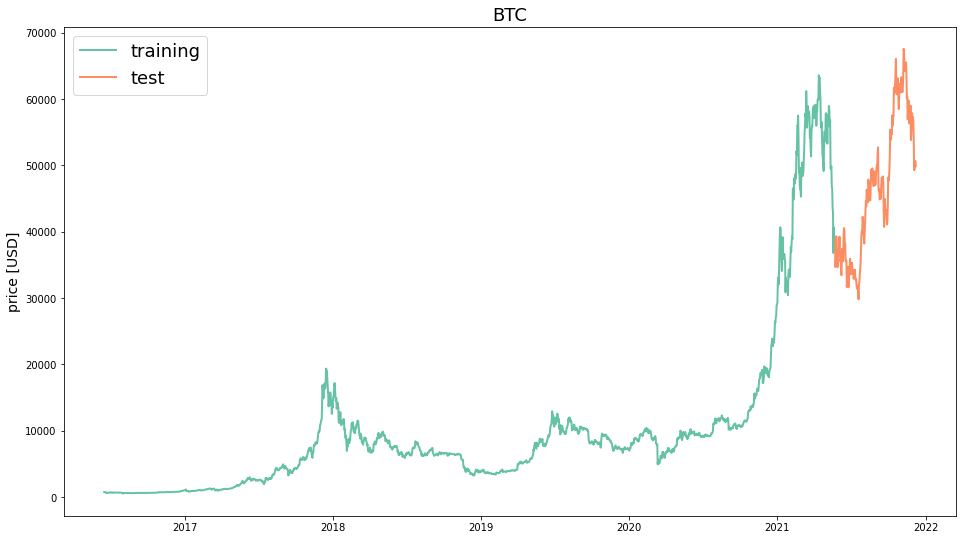

In [9]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

# LSTM - Long short term memory

For training the LSTM, the data was split into windows of 7 days and within each window we normalised the data to zero base, <br>
i.e. the first entry of each window is 0 and all other values represent the change with respect to the first value. <br>
Hence, I am predicting price changes, rather than absolute price.

In [10]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

We used a simple neural network with a single LSTM layer consisting of 20 neurons, <br>
a dropout factor of 0.25, and a Dense layer with a single linear activation function.
<br> In addition, I used Mean Absolute Error (MAE) as loss function.



In [16]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/50
449/449 [==============================] - 4s 4ms/step - loss: 0.0625
Epoch 2/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0435
Epoch 3/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0386
Epoch 4/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0349
Epoch 5/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0341
Epoch 6/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0328
Epoch 7/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0330
Epoch 8/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0323
Epoch 9/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0320
Epoch 10/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0316
Epoch 11/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0311
Epoch 12/50
449/449 [==============================] - 2s 4ms/step - loss: 0.0316
Epoch 13/50
449/449 [====

# Plot Prediction

Using the trained model to predict on the left-out test set.

In [17]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [18]:
mean_absolute_error(preds, y_test)

0.029357847272440476

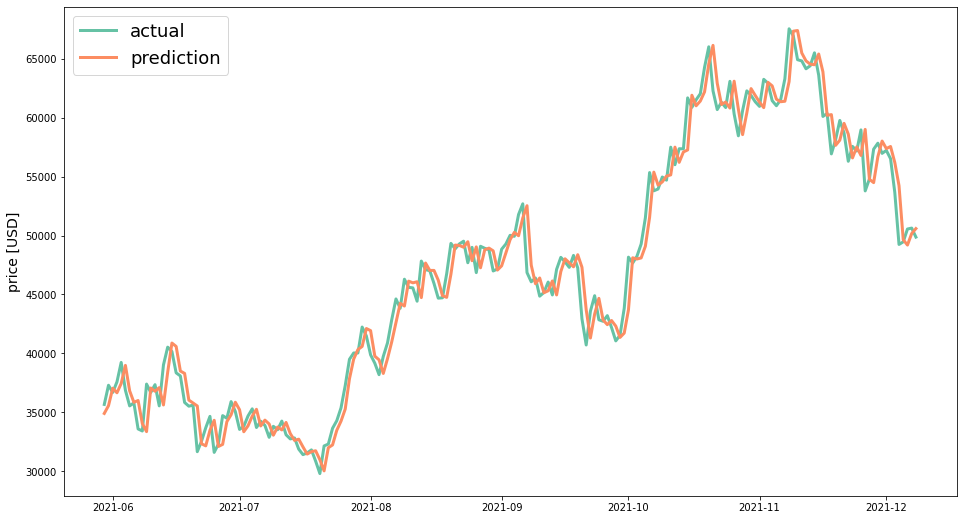

In [19]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

***Let’s take a closer look and zoom into the last 30 days of the plot***

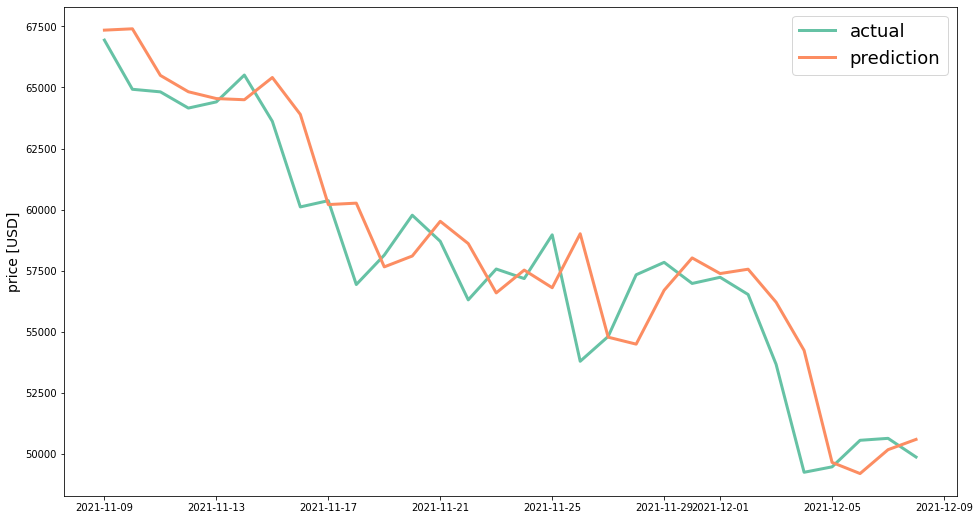

In [20]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

<b> The fundamental flaw with this model is that for the prediction of a particular day, it is mostly using the value of the previous day.
<br>
The prediction line doesn’t seem to be much more than a shifted version of the actual price.
<br>
In fact, if we adjust the predictions and shift them by a day, this observation becomes even more obvious. </b>

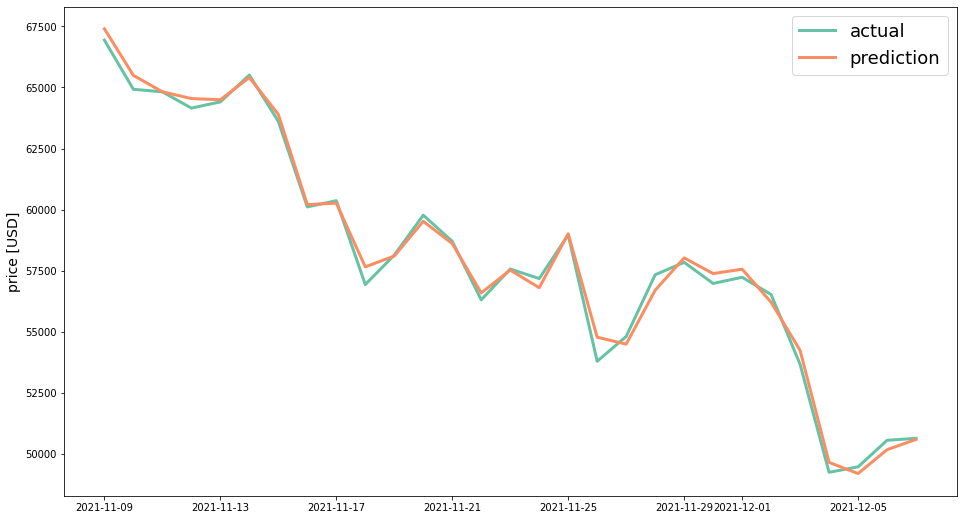

In [21]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

we observe an almost perfect match between actual data and predictions, indicating that the model is essentially learning the price at the previous day.

# Compare Returns

In [22]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

In [23]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

NameError: name 'dual_line_plot' is not defined

Looking at the actual and predicted returns, both in their original form as well as with the 1-day-shift applied to them, we obtain the same observation.

In [ ]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);

As we can see from the plots above, actual and predicted returns are uncorrelated. <br>
Only after applying the 1-day-shift on the predictions we obtain highly correlated returns that resemble the returns of the actual bitcoin data.